In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

# Generating The Data Matrix

In [2]:
n_persons = 40

In [3]:
#Reading the data from the source file
def read_single_image(image_path):
    ans = []
    with open(image_path, 'rb') as f:
        for i in range(10304):
            ans.append(ord(f.read(1)))
    return ans
   
#Constructing our Data frame    
def construct_data_frame():
    
    images = []
    persons = []
    
    path = r'C:\Users\Abdelrahman\Face Recognition Dataset\s'
    for x in range(1, n_persons + 1):
        current_person_path = path + str(x) + '/'
        for y in range(1, 11):
            persons.append(str(x))
            images.append(read_single_image(current_person_path + str(y) + '.pgm'))
            
    images = np.array(images)
   
    return images, persons
            
(Data, labels) = construct_data_frame()

# Train-Test Split

#### Odd-Even Split

In [4]:
#Performing our train_test split function for customizing our splitting technique

def train_test_split_1(data, labels, n_samples):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(n_samples):
        if i%2!=0:
            X_train.append(data[i])
            y_train.append(labels[i])
        else:
            X_test.append(data[i])
            y_test.append(labels[i])
            
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split_1(Data, labels, len(Data))
train_data = pd.DataFrame(X_train,index=y_train)

#### 7-3 Split (Optional)

In [40]:
def train_test_split_2(data, labels, n_samples):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    count=1
    for i in range(n_samples):
        if count>=10:
            X_train.append(data[i])
            y_train.append(labels[i])
        if count<=3:
            X_test.append(data[i])
            y_test.append(labels[i])
        count+=1
        if count  == 11:
            count = 0
            
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split_2(Data, labels, len(Data))
train_data = pd.DataFrame(X_train,index=y_train)

# PCA - Algorithm Implementation

In [5]:
#Calculating mean values
def compute_mean(data):
    return np.mean(data)

In [6]:
#Calculating centers of data
def center(data):
    return data - compute_mean(data)

In [7]:
#Calculating the covariance matrix
def compute_covariance_matrix(data):
    z = center(data)
    return (np.matmul(np.transpose(z), z)) / len(data)

In [8]:
#Calculating the eigen values and eigen vectors
def compute_eig_values_eig_vectors(data):
    cov = compute_covariance_matrix(data)
    eig_values, eig_vectors = np.linalg.eigh(cov)
    idx = eig_values.argsort()[::-1]   
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]
    return eig_values, eig_vectors

In [9]:
#Picking dimentions needed
def dimensionality_reduction(alpha, eig_values):
    sum = np.sum(eig_values)
    r = 0
    i = 0
    for value in eig_values: 
        r = r + eig_values[i]
        i = i + 1
        if (r / sum >= alpha):
            break
    return i

In [10]:
#Calculating reduced dimentions for PCA
def compute_reduced_dimensions(alpha_values, eig_values):
    reduced_dimensions = []
    for alpha in alpha_values:
        reduced_dimensions.append(dimensionality_reduction(alpha, eig_values))
    return reduced_dimensions

# KNN - Classifier Implementation

In [11]:
def KNN_classifier(X_train, y_train, X_test, y_test, n_neighbors):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(X_train, y_train)
    test_samples = len(X_test)
    acc = 0
    y_predict = []
    for i in range(test_samples):
        res = classifier.predict([X_test[i]])
        y_predict.append(res)
        if res == y_test[i]:
            acc += 1
        
    acc /= test_samples
    print(f'Accuracy At K Value = {n_neighbors}: {acc*100} %')
    return acc

# Using PCA with KNN Algorithm

In [12]:
#Using our PCA algorithm for dimentionality reduction
def PCA(data, alpha_values):
    eig_values, eig_vectors = compute_eig_values_eig_vectors(data)
    r = compute_reduced_dimensions(alpha_values, eig_values)
    return r, eig_vectors

Accuracy At K Value = 1: 93.0 %
Accuracy At K Value = 3: 87.0 %
Accuracy At K Value = 5: 82.0 %
Accuracy At K Value = 7: 78.5 %


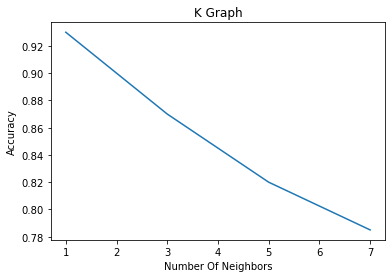

Accuracy At K Value = 1: 94.0 %
Accuracy At K Value = 3: 87.0 %
Accuracy At K Value = 5: 84.5 %
Accuracy At K Value = 7: 79.5 %


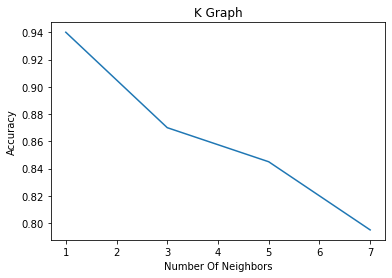

Accuracy At K Value = 1: 94.5 %
Accuracy At K Value = 3: 86.5 %
Accuracy At K Value = 5: 83.5 %
Accuracy At K Value = 7: 77.5 %


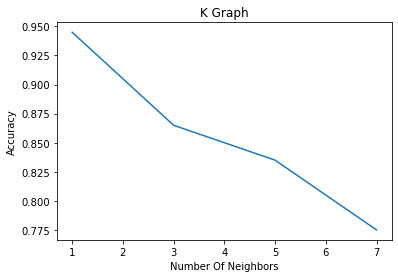

Accuracy At K Value = 1: 93.5 %
Accuracy At K Value = 3: 86.5 %
Accuracy At K Value = 5: 83.5 %
Accuracy At K Value = 7: 77.5 %


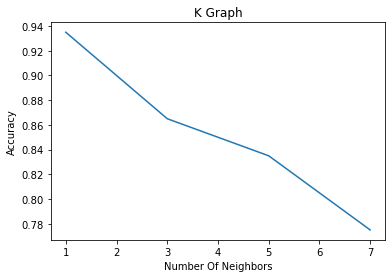

In [13]:
#Main Method
mean = compute_mean(train_data)
z = center(train_data)
r, eig_vectors = PCA(train_data, [0.8, 0.85, 0.9, 0.95])
for i in r:
    U = eig_vectors[:,0:i].T
    train_data_projection = np.array(np.matmul(z, U.T))
    test_data_projection = np.array(np.matmul(X_test - np.array(mean), U.T))
    acc = []
    values_of_k = [1, 3, 5, 7]
    for k_value in values_of_k:
        acc.append(KNN_classifier(train_data_projection, y_train, test_data_projection, y_test, k_value))

    plt.plot(values_of_k, acc)
    plt.xlabel('Number Of Neighbors')
    plt.ylabel('Accuracy')
    plt.title('K Graph')
    plt.show()